<a href="https://colab.research.google.com/github/robinsantos-hue/CSCI167/blob/main/9_5_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 9.5: Augmentation**

This notebook investigates data augmentation for the MNIST-1D model.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-fd2m5p9k
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-fd2m5p9k
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=ab731c9ea5205e5a4ebd0aebf10467cb608069f6896b34411127083616a03350
  Stored in directory: /tmp/pip-ephem-wheel-cache-w5vbhr46/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
D_i = 40    # Input dimensions
D_k = 200   # Hidden dimensions
D_o = 10    # Output dimensions

# Define a model with two hidden layers of size 200
# And ReLU activations between them
model = nn.Sequential(
nn.Linear(D_i, D_k),
nn.ReLU(),
nn.Linear(D_k, D_k),
nn.ReLU(),
nn.Linear(D_k, D_o))

def weights_init(layer_in):
  # Initialize the parameters with He initialization
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)


In [5]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
errors_train = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  print(f'Epoch {epoch:5d}, train error {errors_train[epoch]:3.2f}, test error {errors_test[epoch]:3.2f}')

Epoch     0, train error 56.88, test error 63.70
Epoch     1, train error 44.92, test error 53.60
Epoch     2, train error 32.35, test error 45.00
Epoch     3, train error 25.25, test error 43.10
Epoch     4, train error 25.75, test error 45.50
Epoch     5, train error 19.78, test error 41.20
Epoch     6, train error 13.62, test error 40.20
Epoch     7, train error 13.65, test error 39.80
Epoch     8, train error 8.68, test error 38.90
Epoch     9, train error 4.82, test error 36.40
Epoch    10, train error 4.15, test error 37.60
Epoch    11, train error 3.62, test error 37.00
Epoch    12, train error 3.15, test error 36.60
Epoch    13, train error 1.12, test error 34.50
Epoch    14, train error 0.30, test error 34.80
Epoch    15, train error 0.10, test error 34.30
Epoch    16, train error 0.00, test error 34.80
Epoch    17, train error 0.00, test error 34.90
Epoch    18, train error 0.00, test error 36.20
Epoch    19, train error 0.00, test error 35.80
Epoch    20, train error 0.00, t

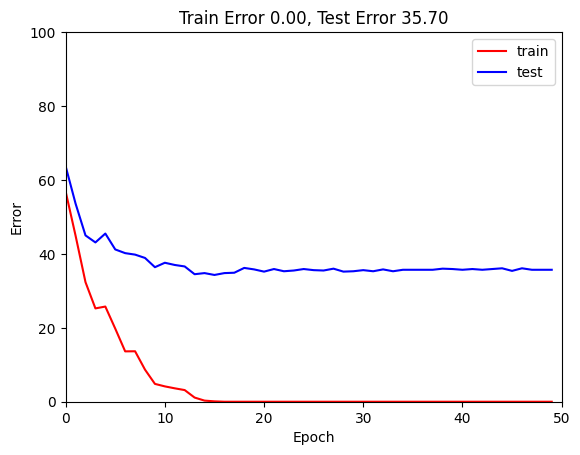

In [6]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Train Error %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

The best test performance is about 33%.  Let's see if we can improve on that by augmenting the data.

In [9]:
def augment(input_vector):
  # Create output vector
  data_out = np.zeros_like(input_vector)

  # TODO:  Shift the input data by a random offset
  # (rotating, so points that would go off the end, are added back to the beginning)
  # Replace this line:
  shift_amount = np.random.randint(0, len(input_vector))
  data_out = np.roll(input_vector, shift_amount, axis=0)

  # TODO:    # Randomly scale the data by a factor drawn from a uniform distribution
  # over [0.8,1.2]
  # Replace this line:
  scale_factor = np.random.uniform(0.8, 1.2)
  data_out = scale_factor * data_out

  return data_out

In [10]:
n_data_orig = data['x'].shape[0]
# We'll double the amount of data
n_data_augment = n_data_orig+4000
augmented_x = np.zeros((n_data_augment, D_i))
augmented_y = np.zeros(n_data_augment)
# First n_data_orig rows are original data
augmented_x[0:n_data_orig,:] = data['x']
augmented_y[0:n_data_orig] = data['y']

# Fill in rest of with augmented data
for c_augment in range(n_data_orig, n_data_augment):
  # Choose a data point randomly
  random_data_index = random.randint(0, n_data_orig-1)
  # Augment the point and store
  augmented_x[c_augment,:] = augment(data['x'][random_data_index,:])
  augmented_y[c_augment] = data['y'][random_data_index]


In [11]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 50 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(augmented_x.astype('float32'))
y_train = torch.tensor(augmented_y.transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
errors_train_aug = np.zeros((n_epoch))
errors_test_aug = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train_aug[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test_aug[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  print(f'Epoch {epoch:5d}, train error {errors_train_aug[epoch]:3.2f}, test error {errors_test_aug[epoch]:3.2f}')

Epoch     0, train error 53.97, test error 57.20
Epoch     1, train error 44.28, test error 48.90
Epoch     2, train error 36.47, test error 45.10
Epoch     3, train error 31.99, test error 41.00
Epoch     4, train error 26.07, test error 41.30
Epoch     5, train error 22.74, test error 36.20
Epoch     6, train error 19.03, test error 37.70
Epoch     7, train error 15.49, test error 38.80
Epoch     8, train error 13.57, test error 37.90
Epoch     9, train error 11.86, test error 37.20
Epoch    10, train error 10.46, test error 35.60
Epoch    11, train error 7.21, test error 33.80
Epoch    12, train error 5.82, test error 34.90
Epoch    13, train error 4.61, test error 35.70
Epoch    14, train error 2.30, test error 33.30
Epoch    15, train error 1.34, test error 33.00
Epoch    16, train error 1.65, test error 34.30
Epoch    17, train error 1.09, test error 32.90
Epoch    18, train error 0.56, test error 32.70
Epoch    19, train error 0.21, test error 34.00
Epoch    20, train error 0.00

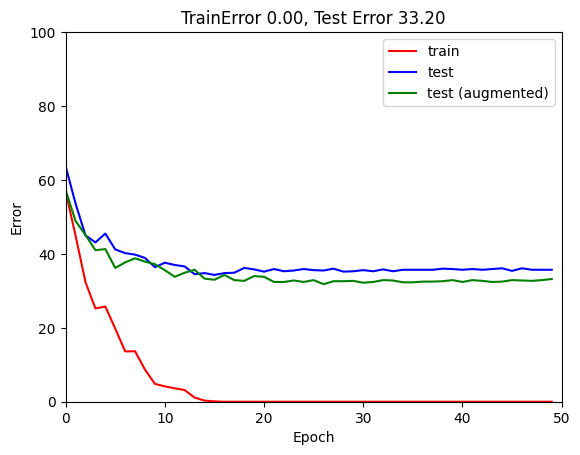

In [12]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.plot(errors_test_aug,'g-',label='test (augmented)')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train_aug[-1],errors_test_aug[-1]))
ax.legend()
plt.show()

Hopefully, you should see an improvement in performance when we augment the data.